In [66]:
from util import (
    read_pickle,
    to_binary_label,
)
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, recall_score, f1_score

import os

import numpy as np
from statistics import mean

def calculate_map_mrr(y_true, y_pred):
    sorted_indices = np.argsort(y_pred)[::-1]

    y_true = y_true[sorted_indices]
    y_pred = y_pred[sorted_indices]
    
    num_relevantes = 0
    map_score = 0
    mrr_score = 0
    
    for i, true_ele in enumerate(y_true):
        if not true_ele:
            break
        else:
            if to_binary_label(y_pred[i]):
                num_relevantes += 1
            map_score = num_relevantes/(i + 1)
            if mrr_score == 0 and map_score != 0:
                mrr_score = map_score
        
    return mrr_score, map_score

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

def list_files(directory):
    files = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):
            files.append(filename)
    return files

def my_confusion_matrix(model_name, y_test, y_pred, map_score, mrr_score, save_path):    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    matrix = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')

    classes = ['Not similar', 'Similar']
    len_classes = len(classes)
    labels = ["{0:0.2%}".format(value) for value in matrix.flatten()]
    
    labels = np.asarray(labels).reshape(len_classes,len_classes)

    res = sns.heatmap(matrix, annot=labels, vmin=0.0, vmax=1, cmap=cmap, fmt='', cbar_kws={"shrink": .82}, xticklabels=classes, yticklabels=classes)

    stats_text = f"\n\nAccuracy: {accuracy:.2%}\nPrecision: {precision:.2%}\nRecall: {recall:.2%}\nF1 Score: {f1:.2%}\n\nMRR Score: {mrr_score:.2%}\nMAP Score: {map_score:.2%}\n"
    
    res.set_xlabel('Predicted Label')
    res.set_ylabel('True Label')
    res.set_title(f'{model_name} Metrics: {stats_text}')
    
    for _, spine in res.spines.items():
        spine.set_visible(True)
    
    
    '''
    # Salvar o plot como um arquivo PNG
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    '''

In [67]:
directory = '../predictions/'
batch_dir = f'../data/test/'
file_name = f"6.10m balanced cosine distance tf-idf lemmatized"
file = read_pickle(f"{directory}{file_name}")
y_true, y_pred = file['y_true'], file['y_pred']

True Positive Rate (Sensitivity): 0.9861685441323257
True Negative Rate (Specificity): 0.8188230607269008
False Positive Rate: 0.18117693927309925
False Negative Rate: 0.013831455867674319
Accuracy: 0.8189347306225648
Precision: 0.003621467615984098
Matthews Correlation Coefficient (MCC): 0.053908916032282476
Balanced Classification Rate (BCR): 0.9024958024296132
AUC-ROC: 0.9024958024296131
AUC-PR: 0.49489962074992616


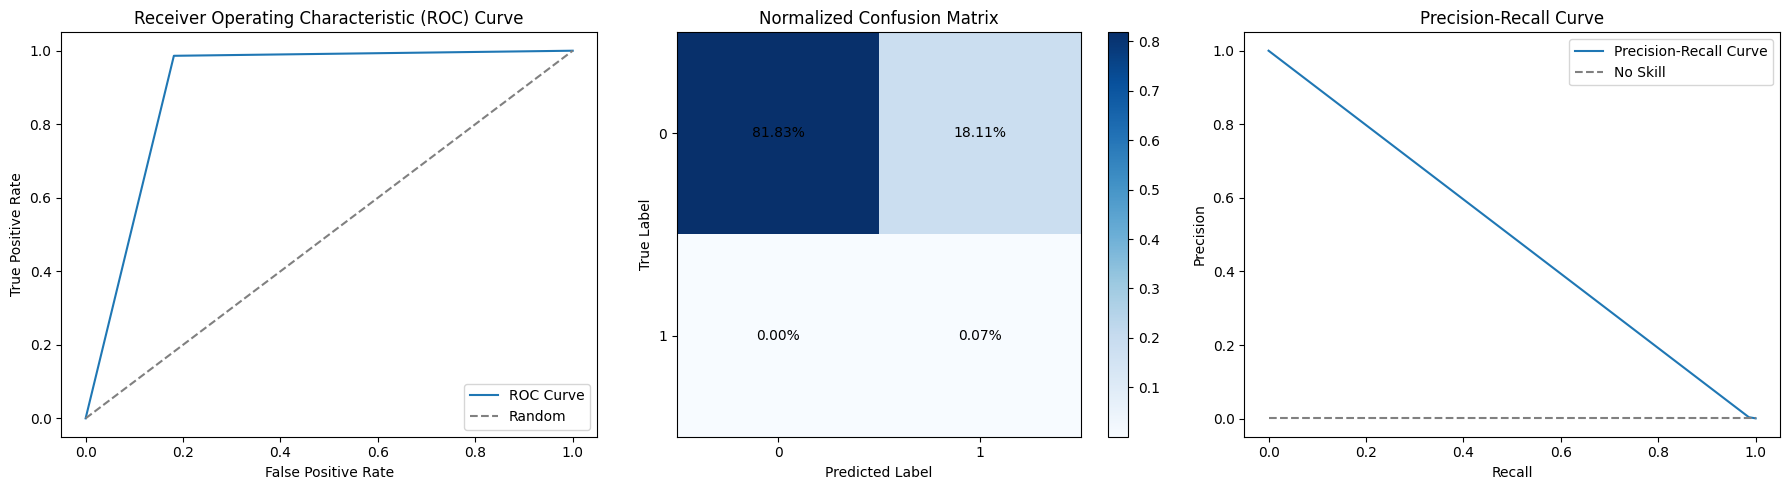

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

def calculate_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='all')  # Normaliza a matriz de confusão

    TN, FP, FN, TP = cm.ravel()

    sensitivity = recall_score(y_true, y_pred)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    bcr = balanced_accuracy_score(y_true, y_pred)

    auc_roc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_curve, precision_curve)

    return sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm

# Chamada da função para obter as métricas e a matriz de confusão
sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm = calculate_metrics(y_true, y_pred)

# Imprimir as métricas
print("True Positive Rate (Sensitivity):", sensitivity)
print("True Negative Rate (Specificity):", specificity)
print("False Positive Rate:", FPR)
print("False Negative Rate:", FNR)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Balanced Classification Rate (BCR):", bcr)
print("AUC-ROC:", auc_roc)
print("AUC-PR:", auc_pr)

# Plotar as curvas ROC e Precision-Recall e a matriz de confusão
plt.figure(figsize=(18, 5))

# Subplot 1: Curva ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Subplot 2: Curva Precision-Recall
plt.subplot(1, 3, 3)
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.plot([0, 1], [len(y_true[y_true==1])/len(y_true)]*2, linestyle='--', color='gray', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Subplot 3: Matriz de Confusão Normalizada
plt.subplot(1, 3, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Adiciona os valores formatados na matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]:.2%}', ha='center', va='center', color='black')

classes = [0, 1]
tick_marks = classes
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


In [69]:
file_name = f"Test PR AUC"
file = read_pickle(f"{directory}{file_name}")
y_true, y_pred = file['y_true'], file['y_pred']

True Positive Rate (Sensitivity): 0.9883074290603165
True Negative Rate (Specificity): 0.809218471181899
False Positive Rate: 0.19078152881810095
False Negative Rate: 0.011692570939683445
Accuracy: 0.8093379775159446
Precision: 0.003447212537488623
Matthews Correlation Coefficient (MCC): 0.05235977932461671
Matthews Correlation Coefficient (MCC): 0.05235977932461672
Balanced Classification Rate (BCR): 0.8987629501211079
AUC-ROC: 0.8987629501211079
AUC-PR: 0.4958812220340908


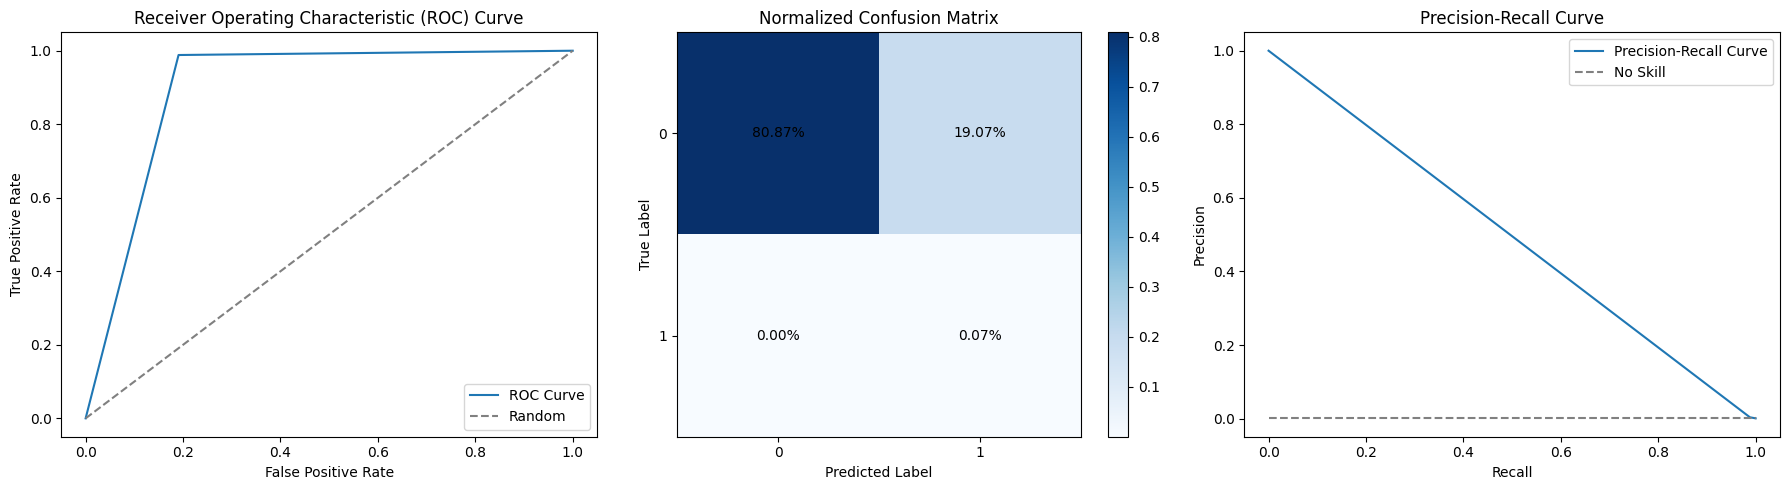

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

def calculate_mcc(tp, tn, fp, fn):
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    if denominator == 0:
        return 0  # Handle division by zero

    mcc = numerator / denominator
    return mcc

def calculate_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='all')  # Normaliza a matriz de confusão

    TN, FP, FN, TP = cm.ravel()

    sensitivity = recall_score(y_true, y_pred)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    my_mcc = calculate_mcc(TP, TN, FP, FN)
    mcc = matthews_corrcoef(y_true, y_pred)
    bcr = balanced_accuracy_score(y_true, y_pred)

    auc_roc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_curve, precision_curve)

    return sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm, my_mcc

# Chamada da função para obter as métricas e a matriz de confusão
sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm, my_mcc = calculate_metrics(y_true, y_pred)

# Imprimir as métricas
print("True Positive Rate (Sensitivity):", sensitivity)
print("True Negative Rate (Specificity):", specificity)
print("False Positive Rate:", FPR)
print("False Negative Rate:", FNR)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Matthews Correlation Coefficient (MCC):", my_mcc)
print("Balanced Classification Rate (BCR):", bcr)
print("AUC-ROC:", auc_roc)
print("AUC-PR:", auc_pr)

# Plotar as curvas ROC e Precision-Recall e a matriz de confusão
plt.figure(figsize=(18, 5))

# Subplot 1: Curva ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Subplot 2: Curva Precision-Recall
plt.subplot(1, 3, 3)
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.plot([0, 1], [len(y_true[y_true==1])/len(y_true)]*2, linestyle='--', color='gray', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Subplot 3: Matriz de Confusão Normalizada
plt.subplot(1, 3, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Adiciona os valores formatados na matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]:.2%}', ha='center', va='center', color='black')

classes = [0, 1]
tick_marks = classes
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


In [71]:
file_name = f"Test PR AUC total data"
file = read_pickle(f"{directory}{file_name}")
y_true, y_pred = file['y_true'], file['y_pred']

True Positive Rate (Sensitivity): 0.007129616426636247
True Negative Rate (Specificity): 0.9999971435315415
False Positive Rate: 2.8564684585420264e-06
False Negative Rate: 0.9928703835733637
Accuracy: 0.9993346015202257
Precision: 0.625
Matthews Correlation Coefficient (MCC): 0.06670459614191794
Balanced Classification Rate (BCR): 0.5035633799790888
AUC-ROC: 0.5035633799790888
AUC-PR: 0.31639608017203885


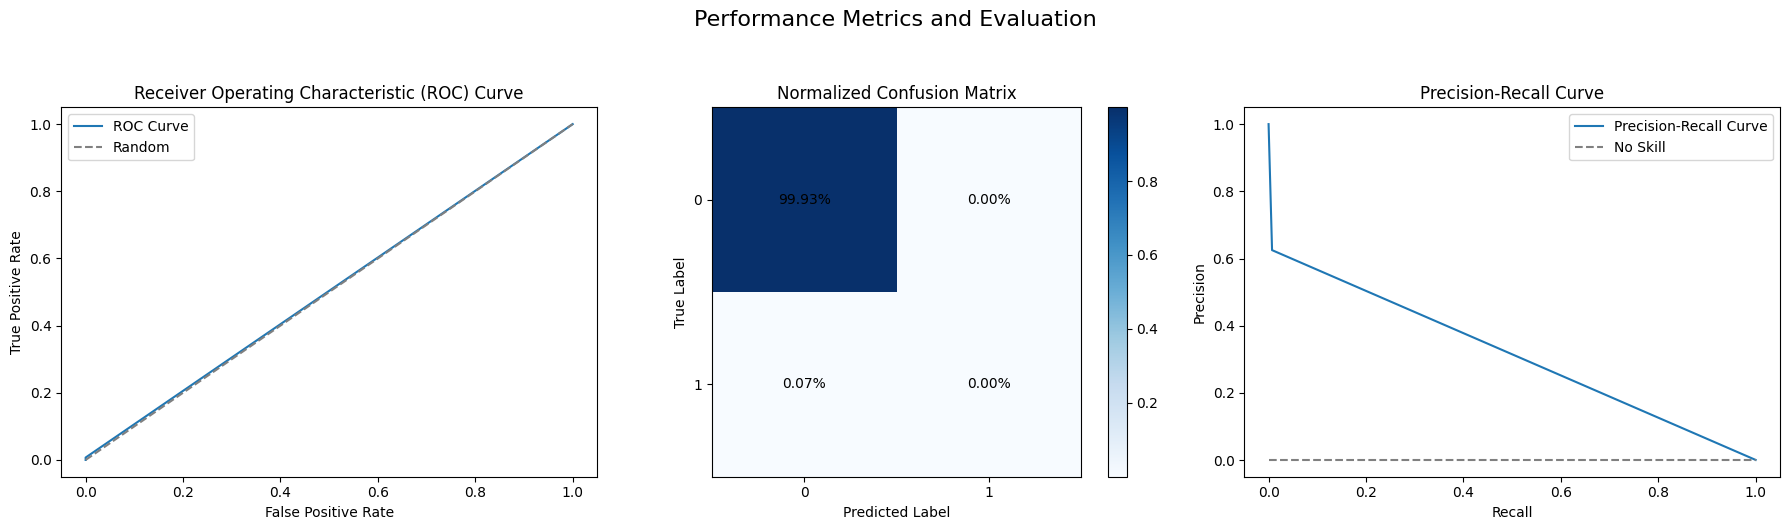

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

def calculate_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='all')  # Normaliza a matriz de confusão

    TN, FP, FN, TP = cm.ravel()

    sensitivity = recall_score(y_true, y_pred)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    bcr = balanced_accuracy_score(y_true, y_pred)

    auc_roc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_curve, precision_curve)

    return sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm

# Chamada da função para obter as métricas e a matriz de confusão
sensitivity, specificity, FPR, FNR, accuracy, precision, mcc, bcr, auc_roc, fpr, tpr, precision_curve, recall_curve, auc_pr, cm = calculate_metrics(y_true, y_pred)

# Imprimir as métricas
print("True Positive Rate (Sensitivity):", sensitivity)
print("True Negative Rate (Specificity):", specificity)
print("False Positive Rate:", FPR)
print("False Negative Rate:", FNR)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Balanced Classification Rate (BCR):", bcr)
print("AUC-ROC:", auc_roc)
print("AUC-PR:", auc_pr)

# Plotar as curvas ROC e Precision-Recall e a matriz de confusão
plt.figure(figsize=(18, 5))

# Subplot 1: Curva ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Subplot 3: Matriz de Confusão Normalizada
plt.subplot(1, 3, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Adiciona os valores formatados na matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]:.2%}', ha='center', va='center', color='black')

classes = [0, 1]
tick_marks = classes
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Subplot 2: Curva Precision-Recall
plt.subplot(1, 3, 3)
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.plot([0, 1], [len(y_true[y_true==1])/len(y_true)]*2, linestyle='--', color='gray', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()


# Adiciona o título geral
plt.suptitle("Performance Metrics and Evaluation", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()